# Supervised learning of tabular data using AutoML

# Table of contents

- [Introduction](#Introduction)
- [Prepare tabular data](#prepare)
- [Train model using AutoML](#AutoML)
- [Reload trained model for prediction](#Reload)

# Introduction
<a id='Introduction'></a> 

Pipeline of activities in a typical machine learning project involves data preprocessing, exploratory data analysis, feature selection/feature engineering, model selection, hyper parameter tuning, generating model explanation and model selection/evaluation. This is an iterative process and data scientists spend a lot of time going through multiple iterations of this pipeline before they are able to identify the best model. AutoML aims to automates this workflow. 

`arcgis.learn` users will now be able to use AutoML for supervised learning classification or regression problems involving tabular data. The AutoML implementation in `arcgis.learn` builds upon the implementation from MLJar (https://github.com/mljar/mljar-supervised) 

# Prepare tabular data
<a id='prepare'></a>

Data can be [feature layer](https://developers.arcgis.com/python/guide/working-with-feature-layers-and-features/), [spatially enabled dataframe](https://developers.arcgis.com/python/guide/introduction-to-the-spatially-enabled-dataframe/) with/without rasters or just a simple dataframe. The data for AutoML is prepared the same way it is prepared for [supervised learning ML Models](https://developers.arcgis.com/python/guide/ml-and-dl-on-tabular-data/).


In [1]:
%matplotlib inline

from IPython.display import Image, HTML
import arcgis
from arcgis.gis import GIS
from arcgis.learn import prepare_tabulardata,AutoML
from sklearn.preprocessing import MinMaxScaler,RobustScaler

Here we will be taking a feature layer hosted on ArcGIS Online, convert it to a spatially enabled dataframe and prepare the data using prepare_tabulardata method from `arcgis.learn`. More details about data preparation for ML Models can be found [here](https://developers.arcgis.com/python/guide/ml-and-dl-on-tabular-data/)

In [2]:
gis=GIS('home')
calgary_no_southland_solar = gis.content.search('calgary_no_southland_solar owner:api_data_owner', 'feature layer')[0]

In [3]:
calgary_no_southland_solar_layer = calgary_no_southland_solar.layers[0]
calgary_no_southland_solar_layer_sdf = calgary_no_southland_solar_layer.query().sdf
calgary_no_southland_solar_layer_sdf=calgary_no_southland_solar_layer_sdf[['FID','date','ID','solar_plan','altitude_m',
                                                                           'latitude','longitude','wind_speed','dayl__s_',
                                                                           'prcp__mm_d','srad__W_m_','swe__kg_m_', 'tmax__deg',
                                                                           'tmin__deg','vp__Pa_','kWh_filled','capacity_f',
                                                                           'SHAPE']]
calgary_no_southland_solar_layer_sdf.head()

,FID,date,ID,solar_plan,altitude_m,latitude,longitude,wind_speed,dayl__s_,prcp__mm_d,srad__W_m_,swe__kg_m_,tmax__deg,tmin__deg,vp__Pa_,kWh_filled,capacity_f,SHAPE
0,1,2017-12-24,355827,Glenmore Water Treatment Plant,1095,51.003078,-114.100571,7.204670,27648.0,1,108.800003,12,-10.5,-21.0,120,1.242357,0.000177,"{""x"": -12701617.407282012, ""y"": 6621838.159138..."
1,2,2017-12-25,355827,Glenmore Water Treatment Plant,1095,51.003078,-114.100571,3.385235,27648.0,1,115.199997,12,-18.0,-29.5,40,2.477714,0.000354,"{""x"": -12701617.407282012, ""y"": 6621838.159138..."
2,3,2017-12-26,355827,Glenmore Water Treatment Plant,1095,51.003078,-114.100571,5.076316,27648.0,0,118.400002,12,-20.0,-32.0,40,3.713071,0.000530,"{""x"": -12701617.407282012, ""y"": 6621838.159138..."
3,4,2017-12-27,355827,Glenmore Water Treatment Plant,1095,51.003078,-114.100571,5.617623,27648.0,0,96.000000,12,-18.0,-26.5,80,4.948429,0.000707,"{""x"": -12701617.407282012, ""y"": 6621838.159138..."
4,5,2017-12-28,355827,Glenmore Water Treatment Plant,1095,51.003078,-114.100571,2.561512,27648.0,0,118.400002,12,-17.0,-28.5,40,6.183786,0.000883,"{""x"": -12701617.407282012, ""y"": 6621838.159138..."


In [4]:
X = ['altitude_m', 'wind_speed', 'dayl__s_', 'prcp__mm_d','srad__W_m_','swe__kg_m_','tmax__deg','tmin__deg','vp__Pa_']
preprocessors =  [('altitude_m', 'wind_speed', 'dayl__s_', 'prcp__mm_d','srad__W_m_','swe__kg_m_','tmax__deg',
                   'tmin__deg','vp__Pa_', RobustScaler())]

In [5]:
data = prepare_tabulardata(calgary_no_southland_solar_layer,
                           'capacity_f',
                           explanatory_variables=X,                           
                           preprocessors=preprocessors)

# Train model using AutoML
<a id='AutoML'></a>

In [6]:
from arcgis.learn import AutoML

AutoML class accepts the following paramters:
- data (Required Paramter): Returned data object from `prepare_tabulardata` function in the previous step.
    
- total_time_limit (Optional parameter): It is the total time in seconds that must be used for AutoML training. Default set is 3600 (1 Hr). At the completion of total_time_limit, the training of AutoML completes and the best model trained until then is used. 
    
- mode (Optional Parameter): Model can be either Explain. Perform or Compete. Default is Explain.

- algorithms (Optional Parameter): This parameter takes in list of algorithms as input. The algorithms could be subset of the following: Linear,Decision Tree,Random Forest,Extra Trees,LightGBM,Xgboost,Neural Network.

- eval_metric (Optional Parameter): The metric to be used to compare models. 

### AutoML modes

- Explain : To to be used when you want to explain and understand the data.
                                      Uses 75%/25% train/test split.
                                      Uses the following models: Baseline, Linear, Decision Tree,
                                      Random Forest, XGBoost, Neural Network, and Ensemble.
                                      Has full explanations in reports: learning curves, importance
                                      plots, and SHAP plots.
- Perform : To be used when you want to train a model that will be used in real-life use cases.
                                      Uses 5-fold CV (Cross-Validation).
                                      Uses the following models: Linear, Random Forest, LightGBM,
                                      XGBoost,Neural Network, and Ensemble.
                                      Has learning curves and importance plots in reports.
- Compete : To be used for machine learning competitions (maximum performance).
                                      Uses 10-fold CV (Cross-Validation).
                                      Uses the following models: Decision Tree, Random Forest, Extra Trees,
                                      XGBoost, Neural Network, Nearest Neighbors, Ensemble,
                                      and Stacking.It has only learning curves in the reports.
 

In [7]:
AutoML_class_obj = AutoML(data=data)

After creating the AutoML object by passing the data obtained from `prepare_tabulardata` and using default values for other parameters, now we proceed to train the model using AutoML. This is done by calling the `fit` method as shown below. New folder will be created and all the models and their varients are saved in that folder. 

In [8]:
AutoML_class_obj.fit()

AutoML directory: AutoML_20
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Linear', 'Decision Tree', 'Random Forest', 'Extra Trees', 'LightGBM', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_DecisionTree rmse 0.050619 trained in 14.53 seconds
2_Linear rmse 0.048289 trained in 6.58 seconds
* Step default_algorithms will try to check up to 5 models
3_Default_LightGBM rmse 0.032221 trained in 9.8 seconds
4_Default_Xgboost rmse 0.033514 trained in 10.93 seconds
5_Default_NeuralNetwork rmse 0.043816 trained in 1.96 seconds
6_Default_RandomForest rmse 0.045735 trained in 3.66 seconds
7_Default_ExtraTrees rmse 0.046594 trained in 3.48 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.032221 trained in 0.17 seconds
AutoML fit time: 56.1 seconds
AutoML best model: 3_Default_LightGBM
Model has

Once the best model is identified after the completion of `fit` method, the model is then saved by calling the `save` method. The transforms and the encoders used on the training data, along with the Esri Model Definition (EMD) file and the dlpk is then saved in the path specified by the user. 

In [ ]:
AutoML_class_obj.save('<Pass the path>')

We can get the score of the best model, visualize the results on validation dataset and also get predictions on new data using the corresponding methods shown below. 

In [9]:
AutoML_class_obj.score()

0.8923446019885948

In [10]:
AutoML_class_obj.show_results()

,altitude_m,capacity_f,dayl__s_,prcp__mm_d,srad__W_m_,swe__kg_m_,tmax__deg,tmin__deg,vp__Pa_,wind_speed,capacity_f_results
3269,1095,0.000464,39052.800781,5,182.399994,4,1.5,-7.5,360,8.556839,0.005607
5425,1090,0.014493,27993.599609,0,115.199997,0,14.0,-1.5,560,10.964577,0.019452
5927,1070,0.288044,58752.000000,2,470.399994,0,23.0,6.5,560,3.339548,0.314754
7428,1094,0.083430,58752.000000,23,201.600006,0,20.5,12.5,1360,6.224127,0.103236
8900,1051,0.007171,41126.398438,11,41.599998,0,-1.5,-3.0,480,7.412553,-0.002827


In [11]:
AutoML_class_obj.predict(data._dataframe.iloc[:100][X],prediction_type="dataframe")

,altitude_m,wind_speed,dayl__s_,prcp__mm_d,srad__W_m_,swe__kg_m_,tmax__deg,tmin__deg,vp__Pa_,prediction_results
0,1095,7.204670,27648.000000,1,108.800003,12,-10.5,-21.0,120,-0.001710
1,1095,3.385235,27648.000000,1,115.199997,12,-18.0,-29.5,40,0.000350
2,1095,5.076316,27648.000000,0,118.400002,12,-20.0,-32.0,40,-0.000757
3,1095,5.617623,27648.000000,0,96.000000,12,-18.0,-26.5,80,-0.000332
4,1095,2.561512,27648.000000,0,118.400002,12,-17.0,-28.5,40,-0.000332
...,...,...,...,...,...,...,...,...,...,...
95,1095,3.887439,50457.601562,0,419.200012,0,26.0,8.0,1080,0.219132
96,1095,5.680981,50457.601562,0,435.200012,0,31.5,10.0,1240,0.189853
97,1095,5.332447,50112.000000,3,195.199997,0,21.0,12.0,1400,0.140498
98,1095,5.281691,49766.398438,7,288.000000,0,24.5,9.0,1160,0.103281


As in the case of `MLModel` and `FullyConnectedNetwork`, predictions can also be obtained in the form of feature class and rasters.

Additionally it is also possible to generate and view the report of all the models trained by the AutoML, the performance and the hyperparamters used in each of the model variant. The report can be generated using the report method as shown below. The reports, also show the learning curves and feature importance charts for each of the model evaluated during the training.  

In [ ]:
AutoML_class_obj.report()

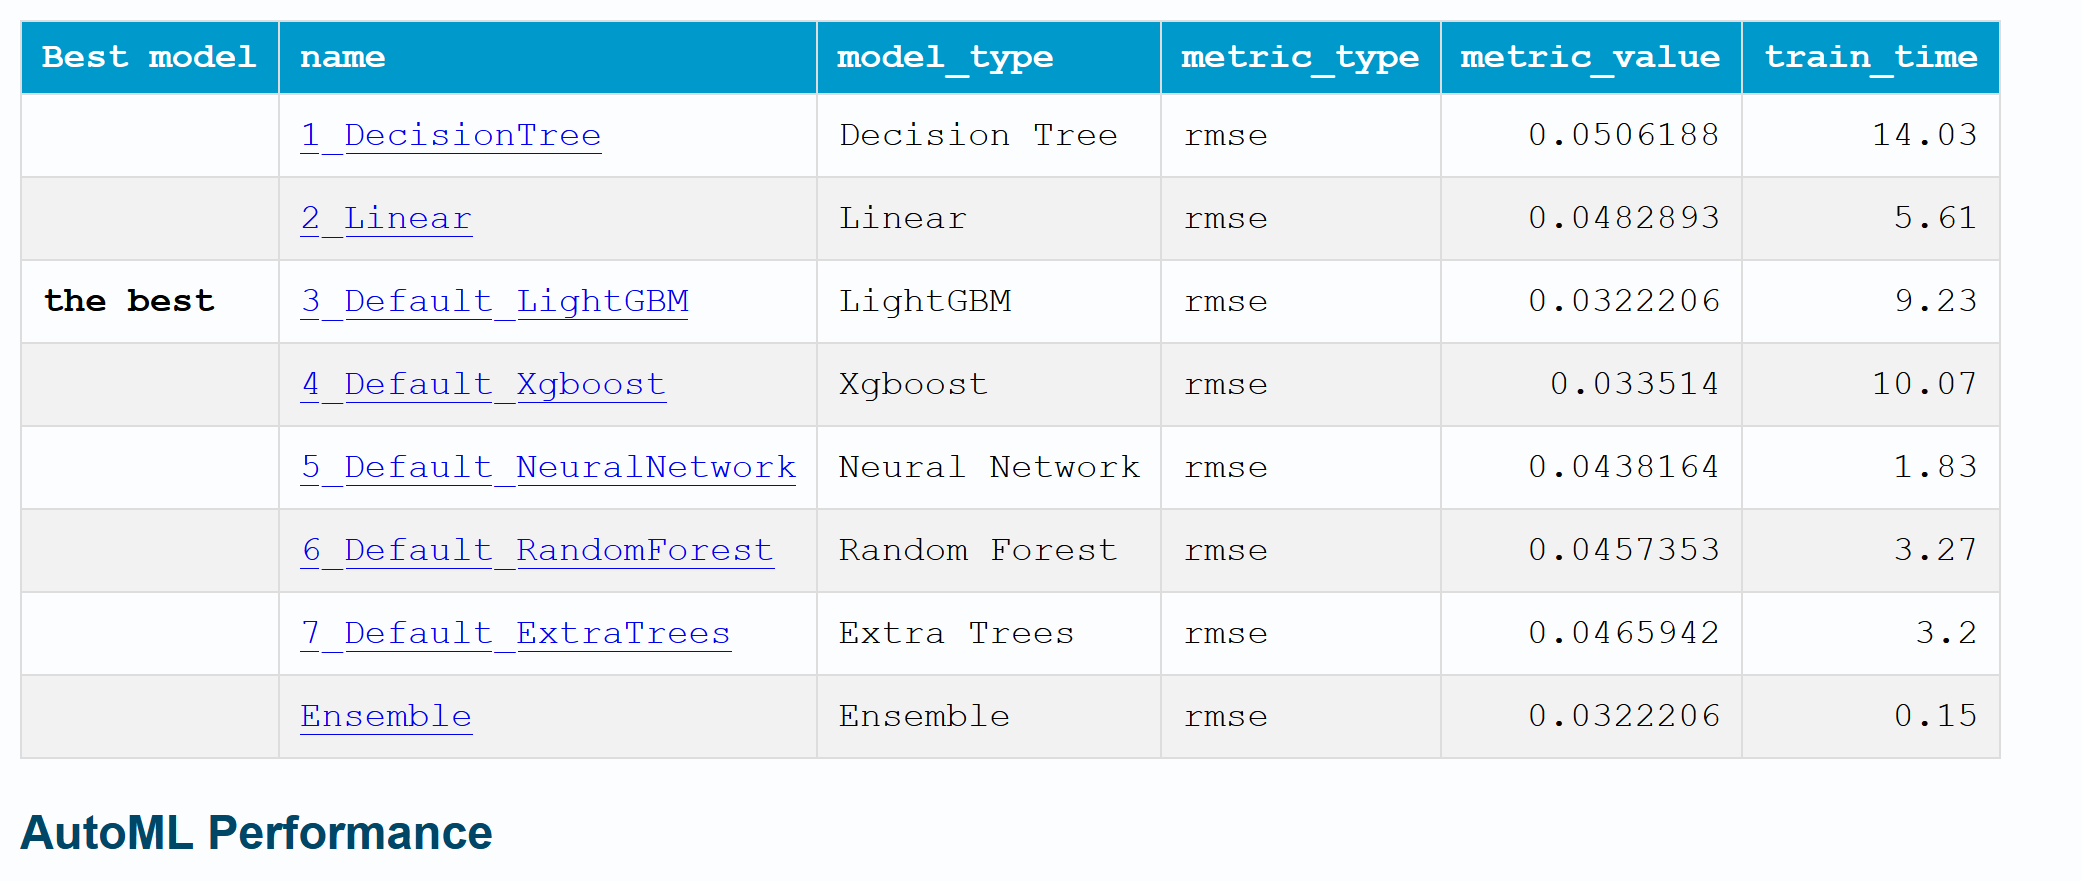

# Reload trained model for prediction
<a id='Reload'></a>

The trained AutoML can be reloaded from the disk to get the predictions on new data. This is done using `from_model` method. This method takes in the path to the emd file as the input. The best model that was identified using the training phase will automatically be picked up and the prediction can be done on the new data using this model by calling the predict method. 

In [1]:
from arcgis.learn import AutoML
AutoML_test_reload=AutoML.from_model(r'<Path to the emd file created after saving the model>')

In [14]:
AutoML_test_reload.predict(data._dataframe.iloc[:100],prediction_type="dataframe")

,altitude_m,capacity_f,dayl__s_,prcp__mm_d,srad__W_m_,swe__kg_m_,tmax__deg,tmin__deg,vp__Pa_,wind_speed,prediction_results
0,1095,0.000177,27648.000000,1,108.800003,12,-10.5,-21.0,120,7.204670,-0.001710
1,1095,0.000354,27648.000000,1,115.199997,12,-18.0,-29.5,40,3.385235,0.000350
2,1095,0.000530,27648.000000,0,118.400002,12,-20.0,-32.0,40,5.076316,-0.000757
3,1095,0.000707,27648.000000,0,96.000000,12,-18.0,-26.5,80,5.617623,-0.000332
4,1095,0.000883,27648.000000,0,118.400002,12,-17.0,-28.5,40,2.561512,-0.000332
...,...,...,...,...,...,...,...,...,...,...,...
95,1095,0.242472,50457.601562,0,419.200012,0,26.0,8.0,1080,3.887439,0.219132
96,1095,0.226795,50457.601562,0,435.200012,0,31.5,10.0,1240,5.680981,0.189853
97,1095,0.136033,50112.000000,3,195.199997,0,21.0,12.0,1400,5.332447,0.140498
98,1095,0.139699,49766.398438,7,288.000000,0,24.5,9.0,1160,5.281691,0.103281
